Using device: cuda


  0%|          | 0/2159 [00:00<?, ?it/s]

tensor(0.) tensor(2.)


  0%|          | 0/2159 [00:00<?, ?it/s]

tensor(0.) tensor(2.)


  0%|          | 0/2159 [00:00<?, ?it/s]

tensor(0.) tensor(2.)
Length of shoe_dataset:  2159
Original samples:  2159 2159
Filtered samples:  300
Training Pair:  (0, 1)
Load Checkpoint from /home/ljb/WassersteinSBP/experiments/gaussian2font_cn/model_0.pt
Training Pair:  (0, 2)
Load Checkpoint from /home/ljb/WassersteinSBP/experiments/gaussian2font_cn/model_1.pt
Training Pair:  (0, 3)
Load Checkpoint from /home/ljb/WassersteinSBP/experiments/gaussian2font_cn/model_2.pt


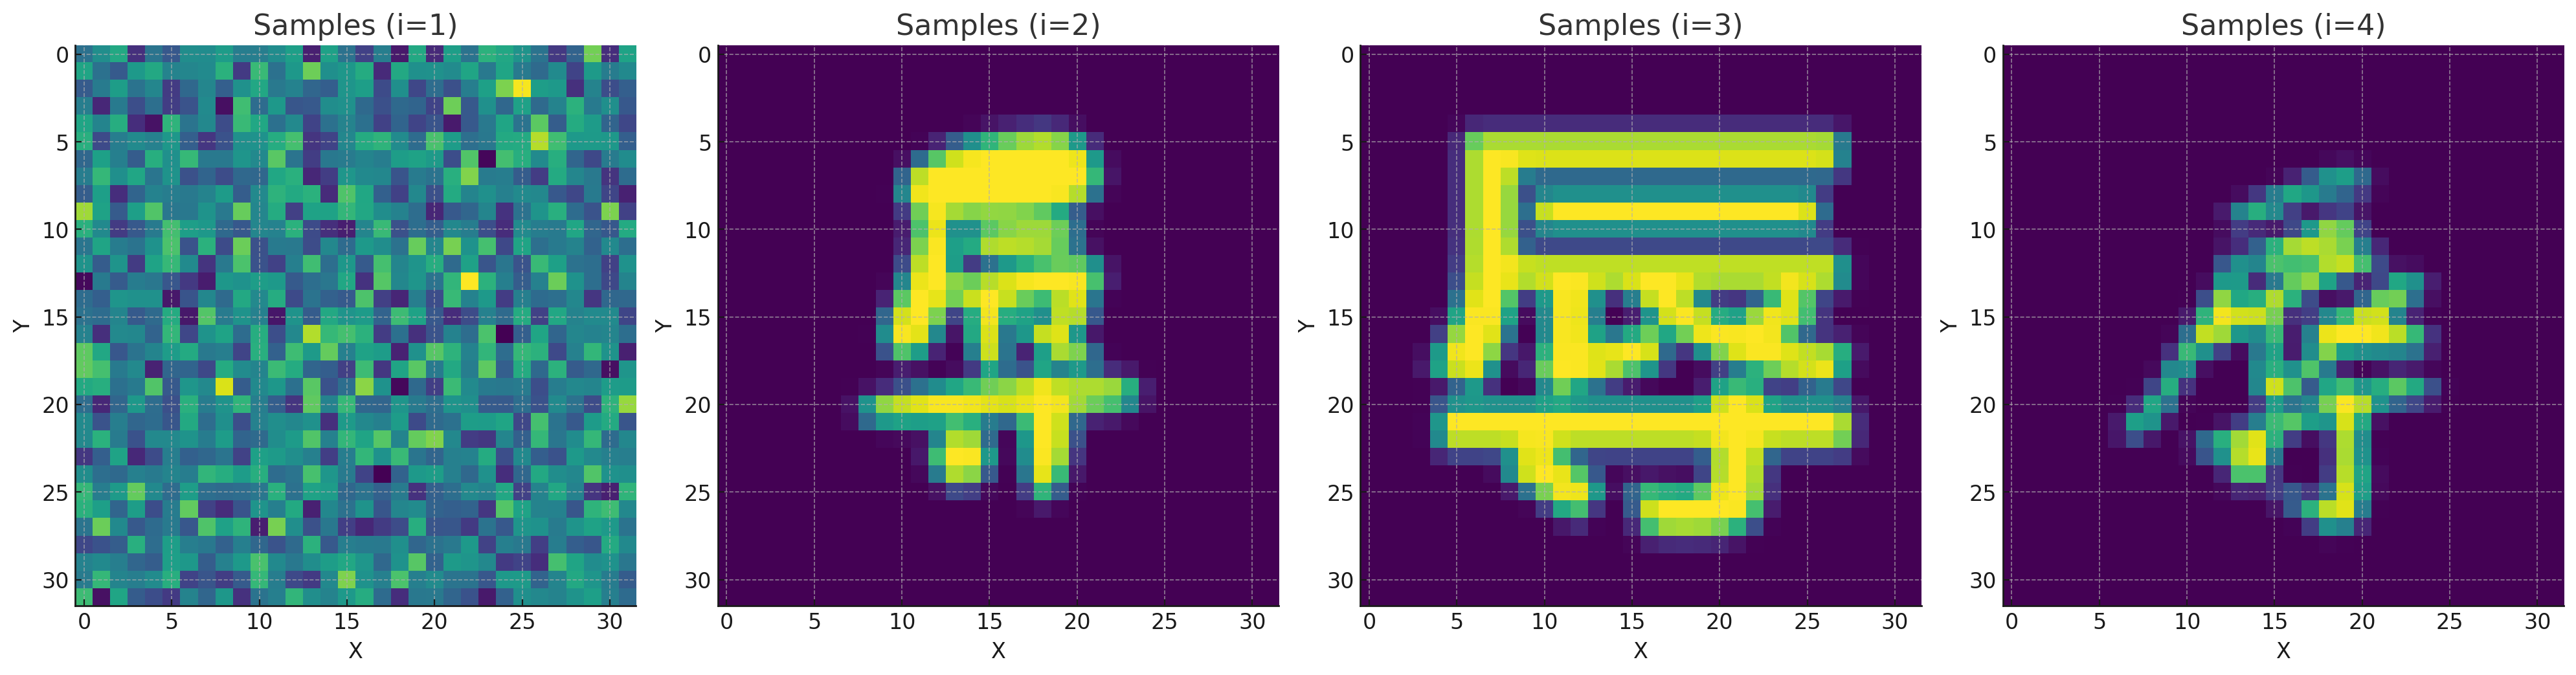

torch.Size([501])
0


  0%|          | 0/500 [00:00<?, ?it/s]

1


  0%|          | 0/500 [00:00<?, ?it/s]

2


  0%|          | 0/500 [00:00<?, ?it/s]

-1


  0%|          | 0/500 [00:00<?, ?it/s]

0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

2


  0%|          | 0/500 [00:00<?, ?it/s]

-2


  0%|          | 0/500 [00:00<?, ?it/s]

1


  0%|          | 0/500 [00:00<?, ?it/s]

-1


  0%|          | 0/500 [00:00<?, ?it/s]

0


  0%|          | 0/500 [00:00<?, ?it/s]

2
(2,)
2
(2,)
2
(2,)
5
(5,)
5
(5,)


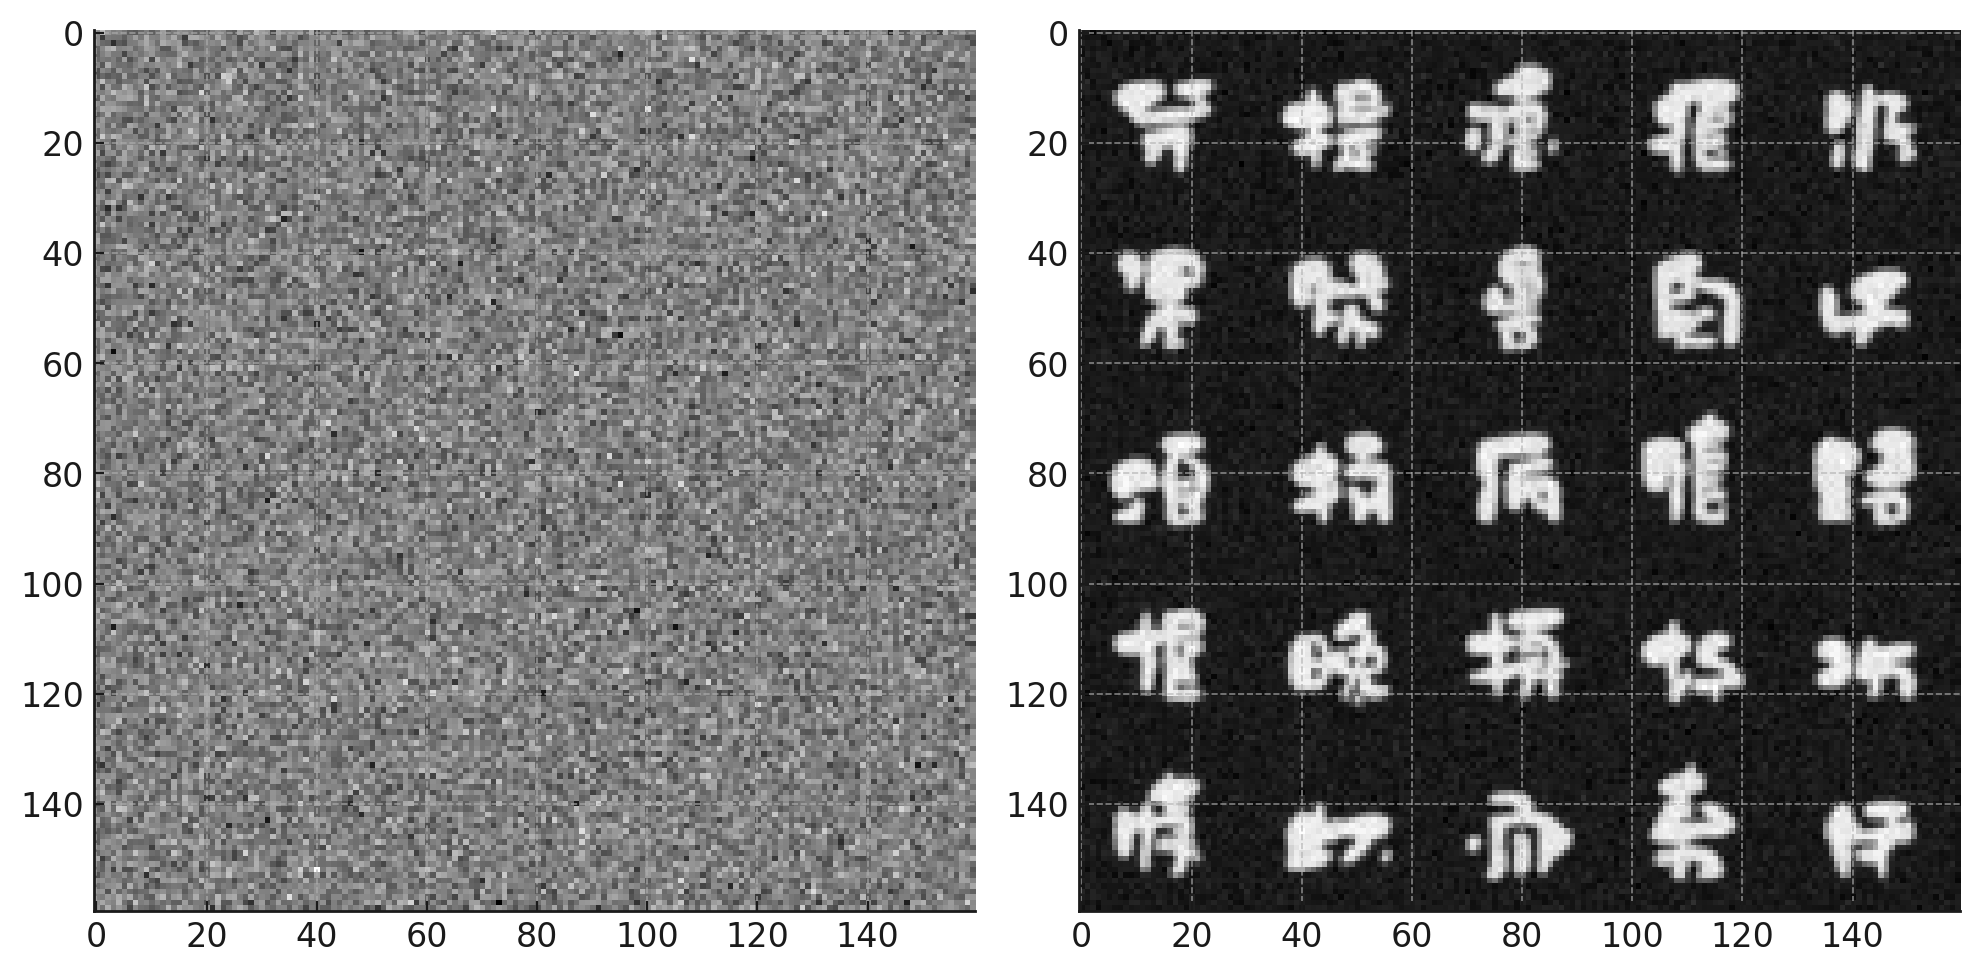

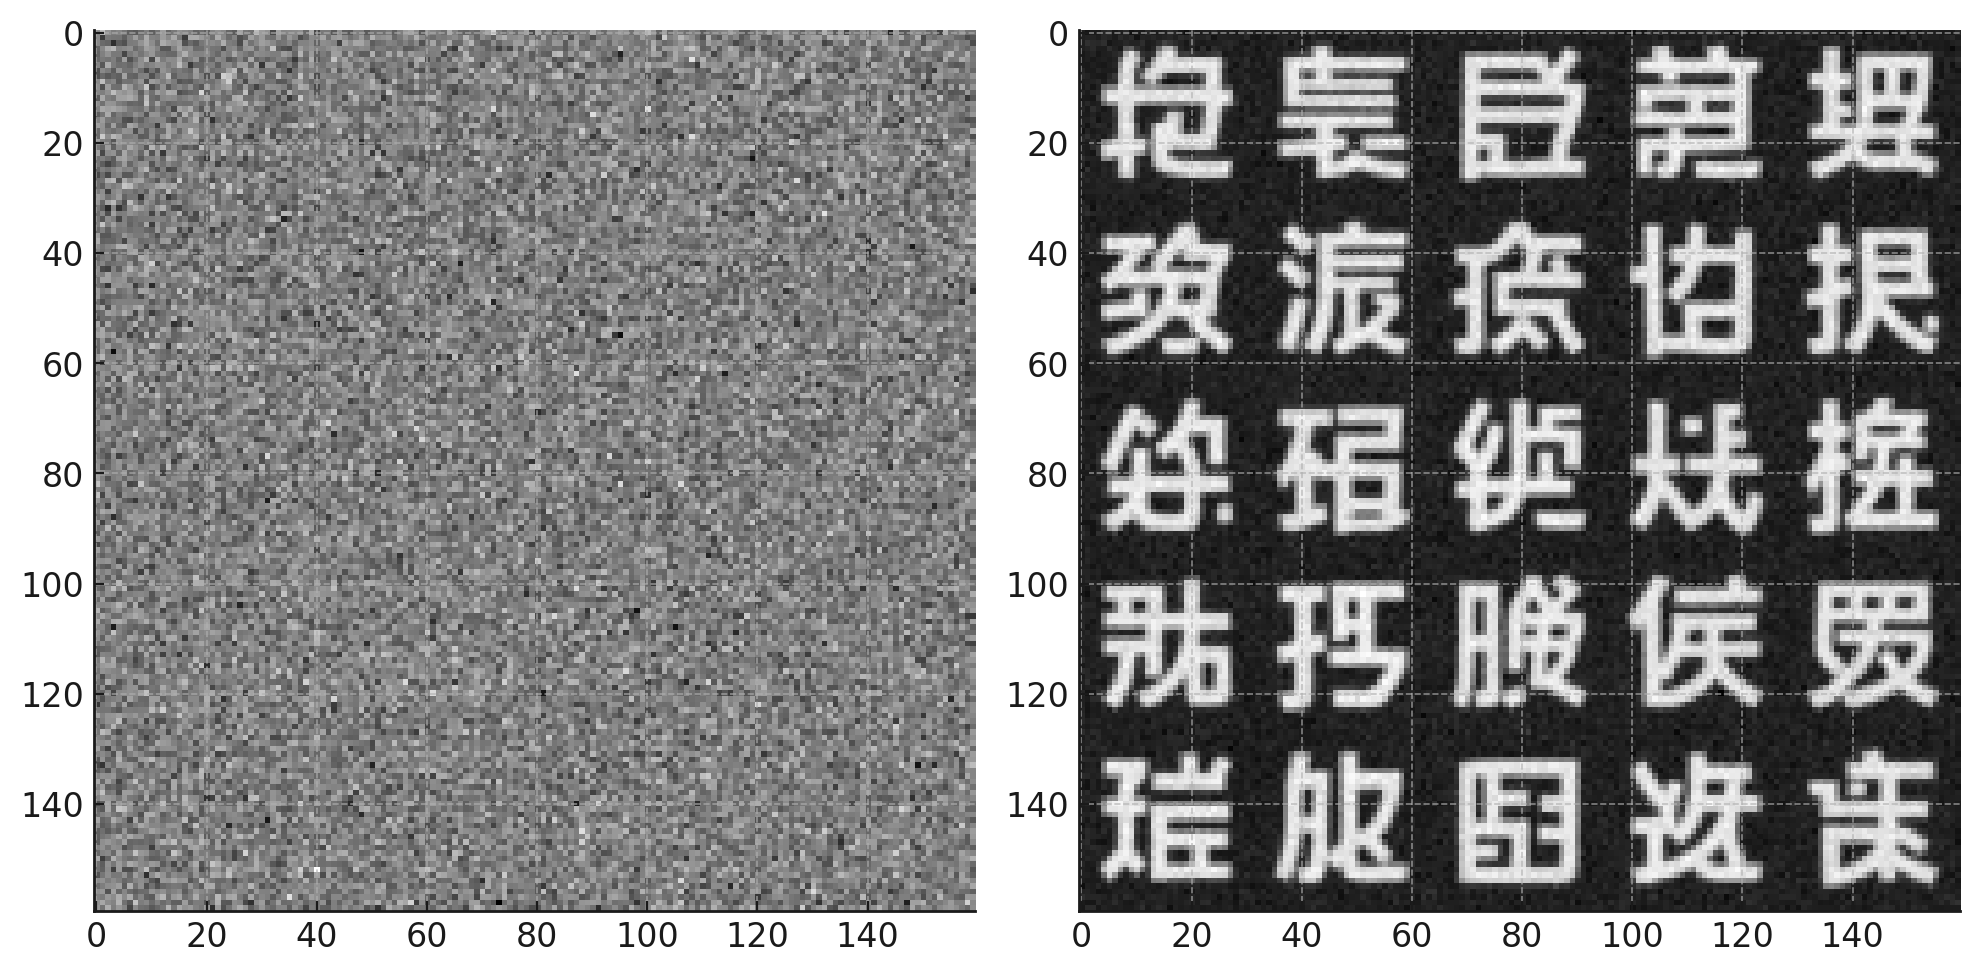

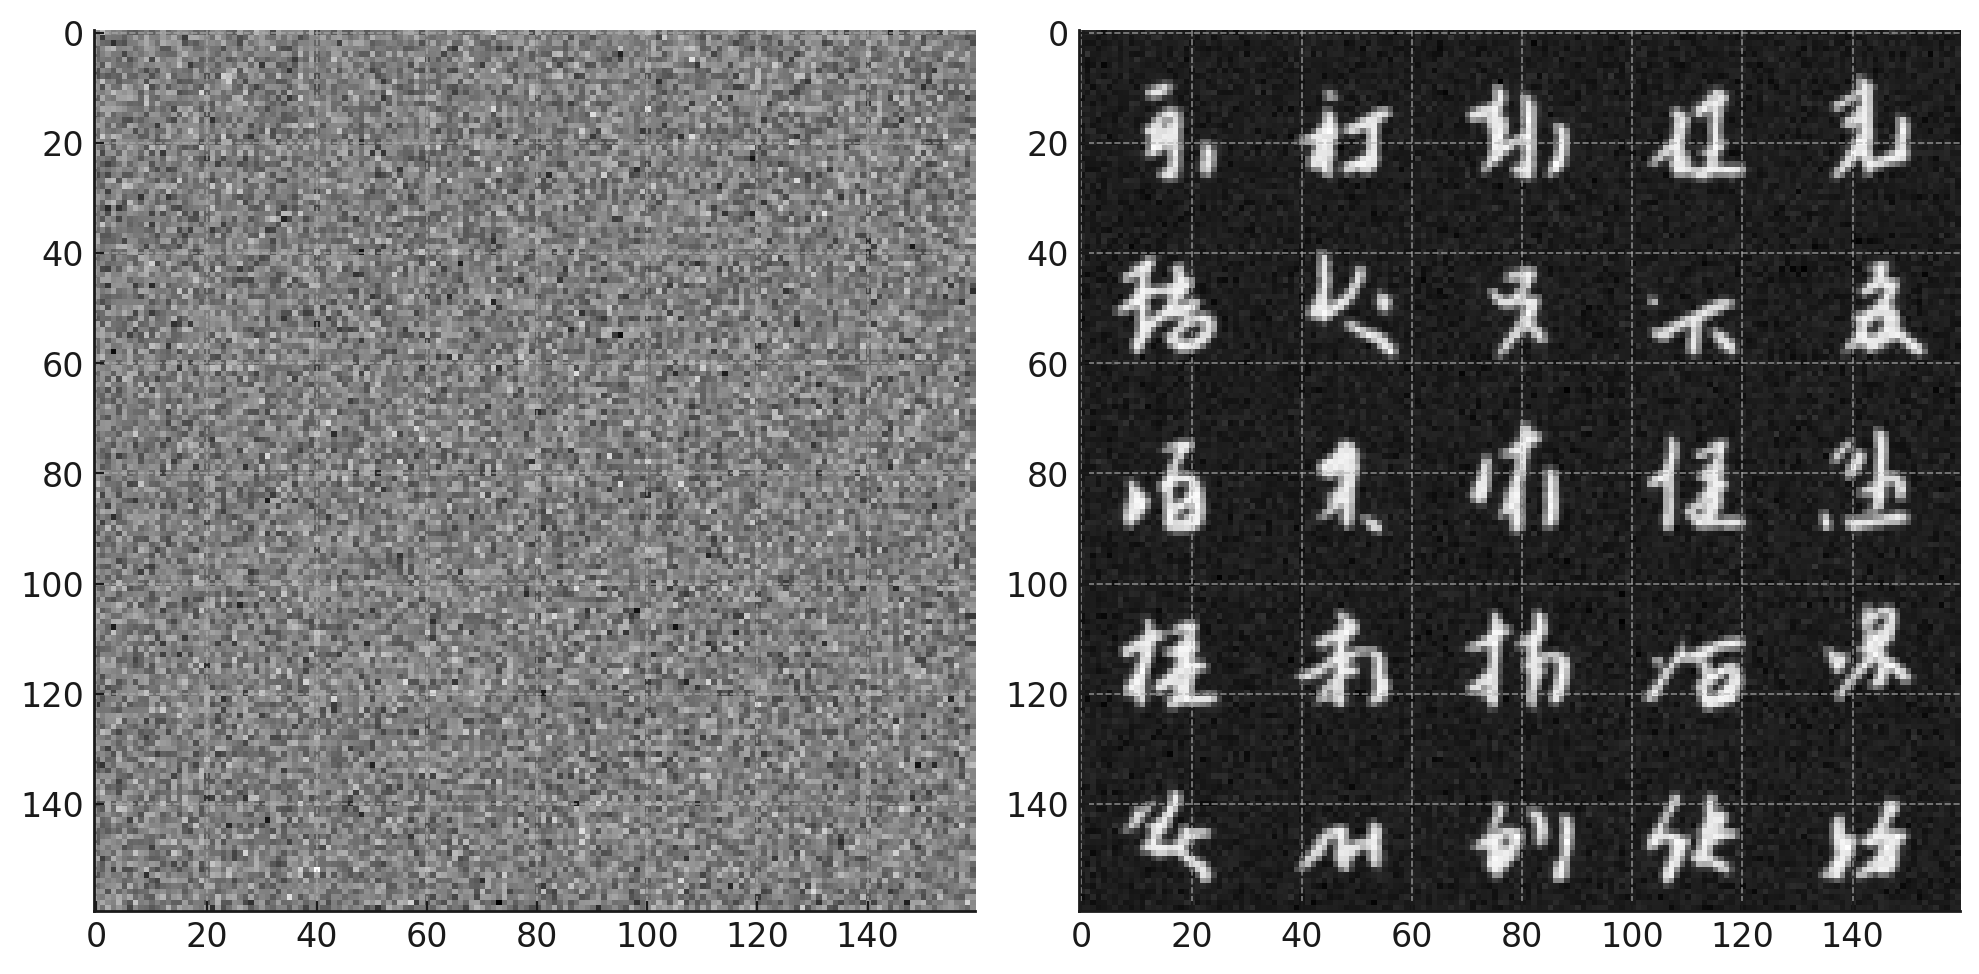

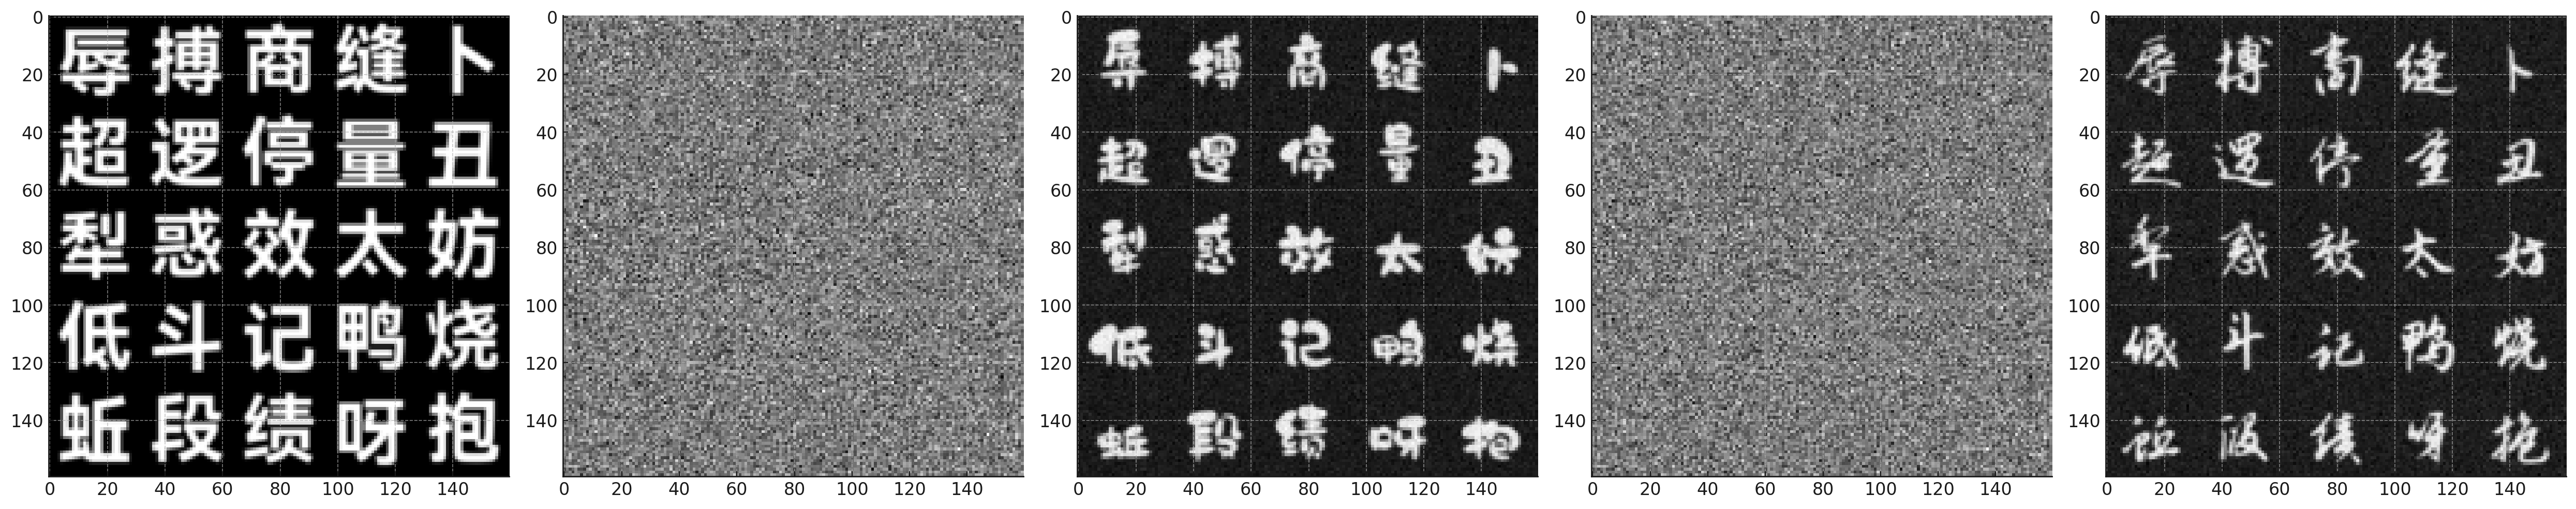

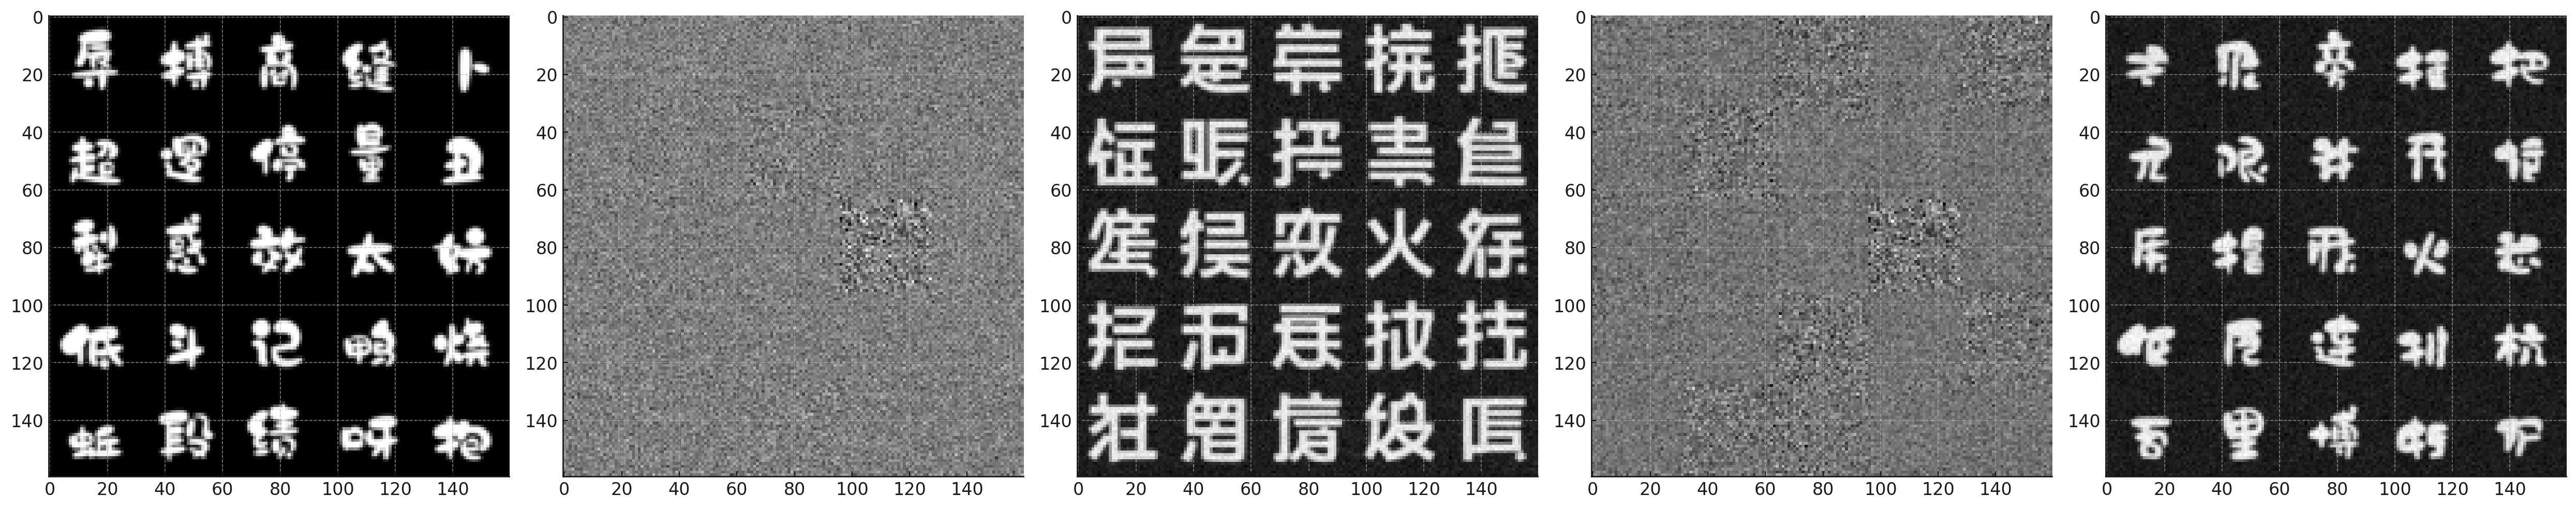

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torchvision.transforms import v2 as transforms
from torch.utils.data import Dataset, DataLoader 
from tqdm.auto import tqdm
from pathlib import Path
torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
image_size = 32
image_channels=1
# set gpu 0
import os
import gc
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

experiment_name = "gaussian2font"
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

def calculate_n_linear_interpolation(marginals, num_timepoints):
    ret = []
    n = num_timepoints + 1
    for i in range(n):  # 0<=alpha<=1
        ret.append((i-1)/(n-1)*marginals[:,1] + (n-i)/(n-1)*marginals[:,0])
    return np.array(ret)

from PIL import Image
class shoeDataset(Dataset):
    def __init__(self, dir, img_names, sketch):
        self.dir = Path(dir)
        train_transform = transforms.Compose([
            transforms.Resize(image_size), 
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            # transforms.Lambda(lambda x: (x-x.min())/(x.max()-x.min())), 
            ])
        self.data = []
        for img_name in tqdm(img_names):
            if sketch:
                img_name = f"{img_name}_1.png"
            else:
                img_name = f"{img_name}.png"
            img_path = self.dir / img_name
            img = train_transform(Image.open(img_path).convert('RGB'))
            # convert to gray
            img = torch.mean(img, dim=0, keepdim=True)
            
            if torch.any(torch.isnan(img)).item():
                print(img_name)
            if img.max() - img.min() == 0:
                print(img_name)
            img = 2 * (img - img.min()) / (img.max() - img.min())
            
            self.data.append(img)
        self.data = torch.stack(self.data)
        print(self.data.min(), self.data.max())
            
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

SIGMA = 1 # 0.02
EPSILON = 0.01

n_channels = image_channels

font1_path = Path("data/chinese_font/yuan")
font2_path = Path("data/chinese_font/heiti")
font3_path = Path("data/chinese_font/cao")
font2_names = [file.name for file in font2_path.glob("*.png")]
vaild_font_names = []

# fake_names = fake_names[-1000:]
for img_name in font1_path.glob("*.png"):
    if f"{img_name.stem}.png" in font2_names:
        vaild_font_names.append(img_name.stem)

font1_dataset = shoeDataset(font1_path, vaild_font_names, False)
font2_dataset = shoeDataset(font2_path, vaild_font_names, False)
font3_dataset = shoeDataset(font3_path, vaild_font_names, False)
print("Length of shoe_dataset: ", len(font1_dataset))
tgt_imgs_1 = font1_dataset
tgt_imgs_2 = font2_dataset
tgt_imgs_3 = font3_dataset

# all_samples = min(len(tgt_imgs_1), len(tgt_imgs_2))
n_samples = 300

# left sample used for test
test_samples = 500

print("Original samples: ", len(tgt_imgs_1), len(tgt_imgs_2))
print("Filtered samples: ", n_samples)

train_nums = n_samples
train_tgt_imgs_1 = torch.stack([font1_dataset[i] for i in range(train_nums)], dim=0)
train_tgt_imgs_2 = torch.stack([font2_dataset[i] for i in range(train_nums)], dim=0)
train_tgt_imgs_3 = torch.stack([font3_dataset[i] for i in range(train_nums)], dim=0)

gauss_samples = torch.randn_like(train_tgt_imgs_1)
# print(train_tgt_imgs_1[0].max())
# print(train_tgt_imgs_1[0].min())
dists = [
    # gauss_samples, 
    # torch.mean(torch.stack([train_tgt_imgs_1, train_tgt_imgs_2]), dim=0), 
    gauss_samples,
    train_tgt_imgs_1, 
    train_tgt_imgs_2, 
    train_tgt_imgs_3, 
    ]

train_pair_list = [
    (0, 1),
    (0, 2),
    (0, 3),
    ]

fig,axs = plt.subplots(1, len(dists), figsize=(len(dists)*5, 5))
for i in range(len(dists)):
    axs[i].imshow(dists[i][0].permute(1,2,0))
    axs[i].set_title(f'Samples (i={i+1})')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
fig.tight_layout()
fig.show()
fig.savefig(log_dir / 'samples.png')



# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = SIGMA
    bridge = torch.zeros((ts.shape[0], num_samples, n_channels , image_size, image_size))
    drift = torch.zeros((ts.shape[0], num_samples, n_channels, image_size, image_size))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn_like(dydt)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

def gen_2d_data(source_dist, target_dist, epsilon=EPSILON, T=1):
    ts = torch.arange(0, T+epsilon, epsilon)
    # source_dist = torch.Tensor(source_dist)
    # target_dist = torch.Tensor(target_dist)
    assert source_dist.shape == target_dist.shape
    num_samples = len(source_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift


def train(model, train_dl, optimizer, scheduler, loss_fn, epoch_iterator):
    losses = 0
    for training_data in train_dl:
        x = training_data['x'].to(device)
        y = training_data['y'].to(device)
        t = training_data['t'].to(device)
        direction = training_data['direction'].to(device)
        if 'status' in training_data:
            status = training_data['status'].to(device)
        else:
            status = None
        pred = model(x, t, direction, status)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = loss.item()
        if scheduler is not None:
            scheduler.step()
        cur_lr = optimizer.param_groups[-1]['lr']
        epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, losses))
        
    return losses


class BasicDataset(Dataset):
    def __init__(self, ts, bridge, drift, direction, status=None):
        # scaled_tensor = normalized_tensor * 2 - 1
        self.times = ts[:len(ts)-1].repeat(n_samples,)
        self.positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)[:, 0]
        self.scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)[:,0]
        self.direction = torch.Tensor([direction])
        self.status = status
        
    def __len__(self):
        return len(self.positions)

    def __getitem__(self, index):
        ret = {
            'x': self.positions[index], 
            'y': self.scores[index],
            't': self.times[index],
            'direction': self.direction,
            }

        if self.status is not None:
            ret['status'] = self.status[index]
        return ret

def get_dl(src_id, tgt_id, dists, batch_size):
    src_dist, tgt_dist = torch.Tensor(dists[src_id]),torch.Tensor(dists[tgt_id])
    gc.collect()
    
    print("Generate Forward Data")
    ts, bridge_f, drift_f = gen_2d_data(src_dist, tgt_dist, epsilon=EPSILON, T=1/2)
    print("Generate Backward Data")
    ts, bridge_b, drift_b = gen_2d_data(tgt_dist, src_dist, epsilon=EPSILON, T=1/2)

    print(ts.shape, bridge_f.shape, drift_f.shape)
    dataset1 = BasicDataset(ts, bridge_f, drift_f, 0)
    dataset2 = BasicDataset(ts, bridge_b, drift_b, 1)
    combined_dataset = ConcatDataset([dataset1, dataset2])

    train_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    return train_dl

from torch.utils.data import ConcatDataset
from utils.unet import UNetModel
model_list = []


checkpoint_path = Path('/home/ljb/WassersteinSBP/experiments/gaussian2font_cn')
# continue_train = True
# checkpoint_path = None 
continue_train = False
for index, pair in enumerate(train_pair_list):
    print("Training Pair: ", pair)
    image_channels=image_channels
    
    num_channels = 64
    num_res_blocks = 4
    num_heads = 4
    num_heads_upsample = -1
    attention_resolutions = "8"
    dropout = 0.1
    use_checkpoint = False
    use_scale_shift_norm = True

    channel_mult = (1, 2, 4)

    attention_ds = []
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))
    kwargs = {
        "in_channels": image_channels,
        "model_channels": num_channels,
        "out_channels": image_channels,
        "num_res_blocks": num_res_blocks,
        "attention_resolutions": tuple(attention_ds),
        "dropout": dropout,
        "channel_mult": channel_mult,
        "num_classes": None,
        "use_checkpoint": use_checkpoint,
        "num_heads": num_heads,
        "num_heads_upsample": num_heads_upsample,
        "use_scale_shift_norm": use_scale_shift_norm,
    }

    model = UNetModel(**kwargs)
    # model = nn.DataParallel(model)
    if checkpoint_path is not None and not continue_train:
        laod_checkpoint_from = checkpoint_path / f"model_{index}.pt"
        print(f'Load Checkpoint from {laod_checkpoint_from}')
        model.load_state_dict(torch.load(laod_checkpoint_from))
    else:
        src_id, tgt_id = pair
        # src_dist, tgt_dist = torch.Tensor(dists[src_id]),torch.Tensor(dists[tgt_id])
        # gc.collect()
        
        # print("Generate Forward Data")
        # ts, bridge_f, drift_f = gen_2d_data(src_dist, tgt_dist, epsilon=EPSILON, T=1/2)
        # print("Generate Backward Data")
        # ts, bridge_b, drift_b = gen_2d_data(tgt_dist, src_dist, epsilon=EPSILON, T=1/2)

        # print(ts.shape, bridge_f.shape, drift_f.shape)
        # dataset1 = BasicDataset(ts, bridge_f, drift_f, 0)
        # dataset2 = BasicDataset(ts, bridge_b, drift_b, 1)
        # combined_dataset = ConcatDataset([dataset1, dataset2])

        epochs = 200
        batch_size = 256
        lr = 1e-3
        refresh_rate = 3
        # train_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        # scheduler = None
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
        loss_fn = nn.MSELoss()
        loss_list = []
        print('='*10+'model'+'='*10)
        # print(model)
        print('='*10+'====='+'='*10)

        if checkpoint_path is not None and continue_train:
            laod_checkpoint_from = checkpoint_path / f"model_{index}.pt"
            print(f'Load Checkpoint from {laod_checkpoint_from}')
            model.load_state_dict(torch.load(laod_checkpoint_from))
        epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
        model.train()
        
        model = model.cuda()
        for e in epoch_iterator:
            if e == 0 or (refresh_rate != 0 and e%refresh_rate==0):
                train_dl = get_dl(src_id, tgt_id, dists, batch_size)
            now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn, epoch_iterator)
            loss_list.append(now_loss)
            cur_lr = optimizer.param_groups[-1]['lr']
            epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
        plt.figure()
        plt.plot(loss_list)
        plt.savefig(log_dir / f'loss_{src_id}_{tgt_id}.png')
        plt.gca().cla()
        epoch_iterator.close()
        torch.save(model.state_dict(), log_dir / f"model_{index}.pt")
        del train_dl
        gc.collect()
        torch.cuda.empty_cache()
    model_list.append(model)
plt.show()

def inference(model, test_ts, test_source_sample, test_num_samples, reverse=False):
    model.eval()
    model.to(device)
    # test_ts = test_ts[:-1]
    sigma = SIGMA
    pred_bridge = torch.zeros(len(test_ts), test_num_samples, n_channels, image_size, image_size)
    pred_drift = torch.zeros(len(test_ts)-1, test_num_samples, n_channels, image_size, image_size)
    pred_bridge[0, :] = test_source_sample
    with torch.no_grad():
        for i in tqdm(range(len(test_ts) - 1)):
            dt = abs(test_ts[i+1] - test_ts[i])
            if reverse:
                direction = torch.ones_like(test_ts[i:i+1])
            else:
                direction: torch.Tensor = torch.zeros_like(test_ts[i:i+1])
            dydt = model(pred_bridge[i].to(device), test_ts[i:i+1].to(device), direction.to(device), None).to('cpu')
            diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, n_channels, image_size, image_size)
            pred_drift[i, :] = dydt
            pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt
            pred_bridge[i+1, :] += diffusion
    return pred_bridge, pred_drift


# 生成样本
test_num_samples = test_samples
test_P2_samples = torch.stack([font1_dataset[i] for i in range(test_num_samples)], dim=0)
test_P3_samples = torch.stack([font2_dataset[i] for i in range(test_num_samples)], dim=0)
test_P4_samples = torch.stack([font3_dataset[i] for i in range(test_num_samples)], dim=0)
test_P1_samples = torch.randn_like(test_P2_samples)
test_ts, test_bridge, test_drift = gen_2d_data(test_P1_samples, test_P2_samples, epsilon=0.001, T=1/2)
print(test_ts.shape)
test_pred_bridges = []
test_pred_drifts = []
infer_chain = [
    # (0,2),
    # (0,1), 
    (0,),
    (1,),
    (2,),
    (-1,0,-3,2),
    (-2,1,-1,0)
    # (-1,0),
    # (-2,1)
    ]
for chain in infer_chain:
    chain_out = []
    drifts = []
    if chain[0] >= 0:
        temp_src = torch.Tensor(test_P1_samples)  
    elif chain[0] == -1:
        temp_src = torch.Tensor(test_P3_samples)
    elif chain[0] == -2:
        temp_src = torch.Tensor(test_P2_samples)
        
        
    for i in chain:
        if i == -3:
            i=0
            reverse = True
        else:
            print(i)
            reverse = i<0
        model = model_list[abs(i)]
        pred_bridge, pred_drift = inference(model, test_ts, temp_src, test_num_samples, reverse=reverse)
        chain_out.append(pred_bridge)
        drifts.append(pred_bridge)
        temp_src = chain_out[-1][-1, :, :].clone()
    test_pred_bridges.append(chain_out)
    test_pred_drifts.append(drifts)

def draw_comapre_split(test_pred_bridges):
    n_sub_interval = len(test_pred_bridges)+1
    print(n_sub_interval)
    fig, axs = plt.subplots(1, n_sub_interval, figsize=(5*n_sub_interval, 5))
    print(axs.shape)
    def plot_test_pred_bridges(sub_axs, data):
        for i in range(n_sub_interval):
            now = data[i][0, :] if i != n_sub_interval-1 else data[i-1][-1, :]
            combined_image = torch.cat([torch.cat([now[j] for j in range(k, k+5)], dim=2) for k in range(0, 25, 5)], dim=1)
            combined_image = (combined_image-combined_image.min())/(combined_image.max()-combined_image.min())
            # combined_image[combined_image<0.3] = 0
            # combined_image[combined_image>0.7] = 1
            
            # combined_image = (combined_image-combined_image.min())/(combined_image.max()-combined_image.min())
            sub_axs[i].imshow(combined_image.permute(1,2,0).numpy(), cmap='gray')
            
    plot_test_pred_bridges(axs, test_pred_bridges)

    # set tight layout
    fig.tight_layout()
    
    # fig
    fig.show()
    
    return fig


def draw_comapre(dists, test_pred_bridges, test_pred_bridges2, test_pred_bridges3, test_pred_bridges4, bound=12):
    n_sub_interval = len(dists)-1
    fig, axs = plt.subplots(4, n_sub_interval, figsize=(5*n_sub_interval, 20))

    def plot_test_pred_bridges(sub_axs, data):
        for i in range(n_sub_interval):
            now = data[i][0, :] if i != n_sub_interval-1 else data[i-1][-1, :]
            combined_image = torch.cat([torch.cat([now[j] for j in range(k, k+5)], dim=2) for k in range(0, 25, 5)], dim=1)

            sub_axs[i].imshow(combined_image.permute(1,2,0).numpy(), cmap='gray')
            
    plot_test_pred_bridges(axs[0], test_pred_bridges)
    axs[0][0].set_ylabel('Chain 0 -> 1 -> 2')
    
    axs[1][0].set_ylabel('Chain 0 -> 1 -> 3')
        
    
    plot_test_pred_bridges(axs[1], test_pred_bridges2)

    plot_test_pred_bridges(axs[2], test_pred_bridges3)
    axs[2][0].set_ylabel('Chain 2 -> 1 -> 3')
    plot_test_pred_bridges(axs[3], test_pred_bridges4)
    axs[3][0].set_ylabel('Chain 3 -> 1 -> 2')

    # set tight layout
    fig.tight_layout()
    
    # fig
    fig.show()
    
    return fig
    
# draw_comapre(dists, test_pred_bridges[0], test_pred_bridges[1], test_pred_bridges[2], test_pred_bridges[3]).savefig(log_dir / 'compare.png')

for i in range(len(test_pred_bridges)):
    draw_comapre_split(test_pred_bridges[i]).savefig(log_dir / f'compare_{i}.png')
# draw_comapre_split(test_pred_bridges[-1]).savefig(log_dir / f'compare_{i}.png')
import imageio
import shutil
from rich.progress import track

def save_gif_frame(bridge, save_path=None, name='brownian_bridge.gif'):
    assert save_path is not None, "save_path cannot be None"
    save_path = Path(save_path)
    if len(bridge) > 200:
        # downsample to 100
        downsample_rate = len(bridge) // 100
        bridge = bridge[::downsample_rate]

    temp_dir = save_path / 'temp'
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
    temp_dir.mkdir(exist_ok=True)
    frame = 0
    
    for i in track(range(bridge.shape[0]), description="Processing image"):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        now = bridge[i, :]
        combined_image = torch.cat([torch.cat([now[j] for j in range(k, k+5)], dim=2) for k in range(0, 25, 5)], dim=1)
        ax.imshow(combined_image.permute(1,2,0).numpy(), cmap='gray')
        fig.savefig(save_path / 'temp' / f'{frame:03d}.png', dpi=100)
        frame += 1
        fig.show()
        plt.close('all')
    frames = []
    for i in range(bridge.shape[0]):
        frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')
        frames.append(frame_image)
    imageio.mimsave(save_path / name, frames, duration=0.2)
    if temp_dir.exists():
        shutil.rmtree(temp_dir)

# for i, test_pred_bridge in enumerate(test_pred_bridges):
#     save_gif_frame(torch.concat(test_pred_bridge, dim=0), log_dir, name=f"pred_{i}.gif")


In [106]:
len(test_pred_bridges[-2])

4

In [92]:
from losses import pytorch_ssim
test_P2_samples
test_P3_samples.shape

torch.Size([500, 1, 32, 32])

In [181]:
def draw_batch(batch):
    batch = batch[:25]
    combined_image = torch.cat([torch.cat([batch[j] for j in range(k, k+5)], dim=2) for k in range(0, 25, 5)], dim=1)
    img_array = combined_image.permute(1,2,0).numpy()
    percentile_1 = np.percentile(img_array, 72)
    percentile_99 = np.percentile(img_array, 100)
    img_array = np.clip((img_array - percentile_1) / (percentile_99 - percentile_1), 0, 1)
    plt.imshow(img_array, cmap='gray')
    plt.grid(False)
    plt.show()

In [182]:
test_pred_bridges[-1][0].shape

torch.Size([501, 500, 1, 32, 32])

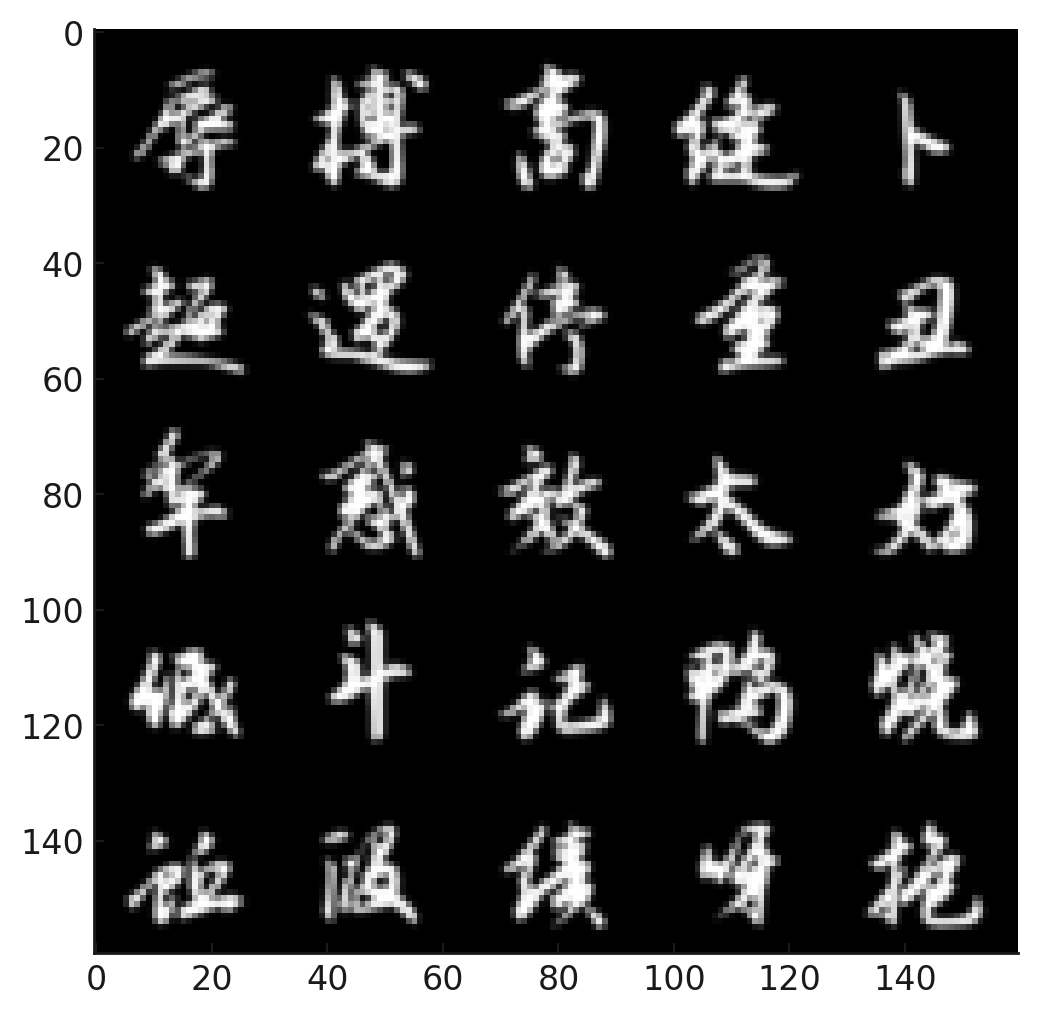

In [201]:
draw_batch(test_P4_samples)

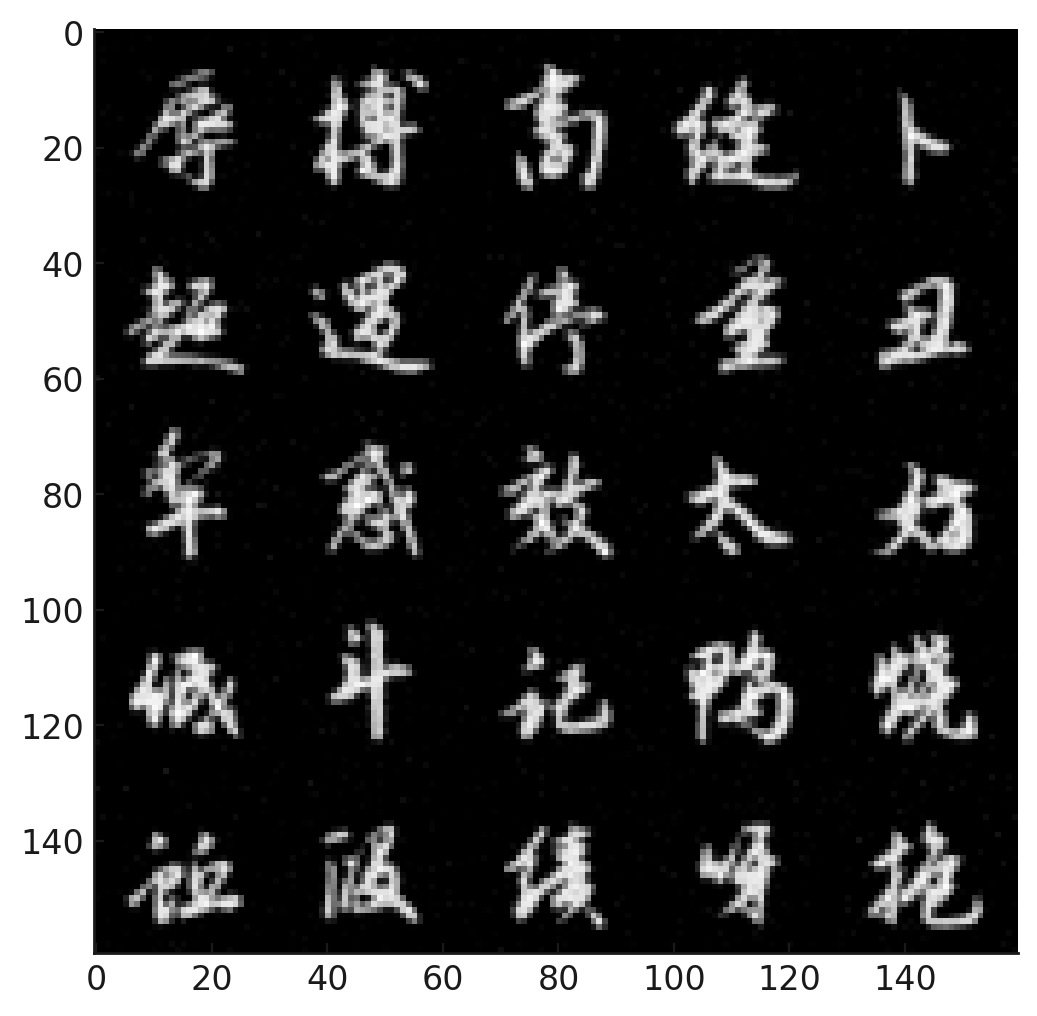

In [202]:
draw_batch(test_pred_bridges[-2][-1][-1])

In [203]:
from PIL import Image
for i, img_tensor in enumerate(test_P4_samples):
    img_array = img_tensor[0].numpy()
    img_array = (img_array/2*255).astype(np.uint8)
    img = Image.fromarray(img_array).convert('RGB')
    img.save(f'fid/高斯2幼圆/1/{i}.png')
    
for i, img_tensor in enumerate(test_pred_bridges[-2][-1][-1]):
    img_array = img_tensor[0].numpy()
    percentile_1 = np.percentile(img_array, 72)
    percentile_99 = np.percentile(img_array, 100)

    img_array = np.clip((img_array - percentile_1) / (percentile_99 - percentile_1), 0, 1)
    img_array = (img_array*255).astype(np.uint8)
    # print(img_array.min(),img_array.max())
    img = Image.fromarray(img_array).convert('RGB')
    img.save(f'fid/高斯2幼圆/2/{i}.png')
    

In [1]:
import torchvision
mnist_ds = torchvision.datasets.MNIST(
    root="./data/", 
    train=True, 
    download=True
    )

for ind, i in enumerate(mnist_ds):
    i[0].save(f"/home/ljb/WassersteinSBP/data/mnist_new/{ind}.png")
    
    if ind>10000:
        break
    

In [186]:
from torch.autograd import Variable

def norm(batch):
    img_array = batch.numpy()
    percentile_1 = np.percentile(img_array, 74)
    percentile_99 = np.percentile(img_array, 98)
    img_array = np.clip((img_array - percentile_1) / (percentile_99 - percentile_1), 0, 1)
    return torch.Tensor(img_array)

pytorch_ssim.ssim(Variable(norm(test_P2_samples)),Variable(norm(test_pred_bridges[-2][1][-1])))

tensor(0.8166)

In [101]:
pytorch_ssim.ssim(Variable(test_P3_samples),Variable(test_pred_bridges[-1][1][-1]))

tensor(0.2472)

Using device: cuda


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(0.) tensor(4.)
Length of shoe_dataset:  5000
Original samples:  5000
Filtered samples:  100
Training Pair:  (0, 1)
Load Checkpoint from /home/ljb/WassersteinSBP/experiments/gaussian2emnist_new/model_0.pt


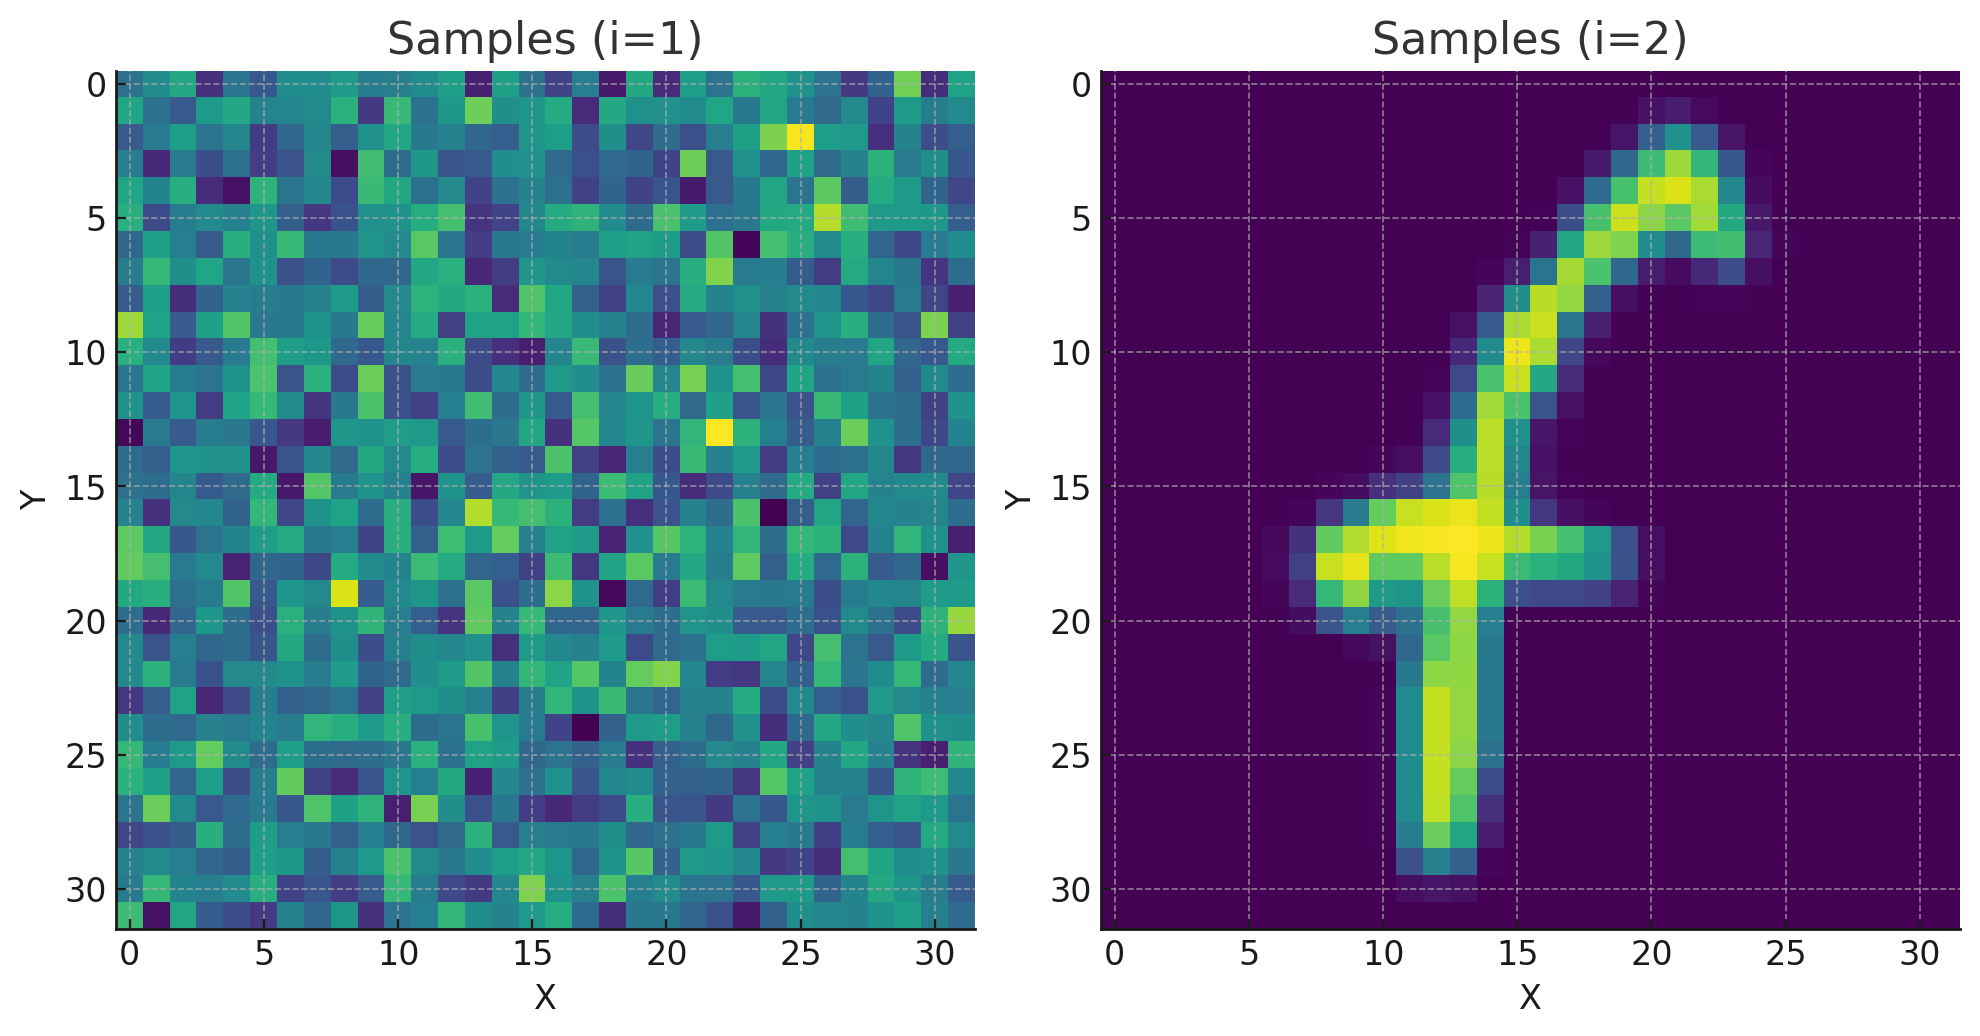

torch.Size([501])
0


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torchvision.transforms import v2 as transforms
from torch.utils.data import Dataset, DataLoader 
from tqdm.auto import tqdm
from pathlib import Path
torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
image_size = 32
image_channels=3
# set gpu 0
import os
import gc
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

experiment_name = "gaussian2emnist_new"
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

def calculate_n_linear_interpolation(marginals, num_timepoints):
    ret = []
    n = num_timepoints + 1
    for i in range(n):  # 0<=alpha<=1
        ret.append((i-1)/(n-1)*marginals[:,1] + (n-i)/(n-1)*marginals[:,0])
    return np.array(ret)

from PIL import Image
class shoeDataset(Dataset):
    def __init__(self, dir, img_names, sketch):
        self.dir = Path(dir)
        train_transform = transforms.Compose([
            transforms.Resize(image_size), 
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            # transforms.Lambda(lambda x: (x-x.min())/(x.max()-x.min())), 
            ])
        self.data = []
        for img_name in tqdm(img_names):
            if sketch:
                img_name = f"{img_name}_1.png"
            else:
                img_name = f"{img_name}.png"
            img_path = self.dir / img_name
            img = train_transform(Image.open(img_path).convert('RGB'))
            # convert to gray
            img = torch.mean(img, dim=0, keepdim=True)
            
            if torch.any(torch.isnan(img)).item():
                print(img_name)
            if img.max() - img.min() == 0:
                print(img_name)
            img = 4 * (img - img.min()) / (img.max() - img.min())
            
            self.data.append(img)
        self.data = torch.stack(self.data)
        print(self.data.min(), self.data.max())
            
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

SIGMA = 1 # 0.02
EPSILON = 0.05

n_channels = image_channels

font1_path = Path("data/emnist_new")
vaild_font_names = [file.stem for file in font1_path.glob("*.png")]

font1_dataset = shoeDataset(font1_path, vaild_font_names, False)


print("Length of shoe_dataset: ", len(font1_dataset))
tgt_imgs_1 = font1_dataset

# all_samples = min(len(tgt_imgs_1), len(tgt_imgs_2))
n_samples = 100

# left sample used for test
test_samples = 25

print("Original samples: ", len(tgt_imgs_1))
print("Filtered samples: ", n_samples)

train_nums = n_samples
train_tgt_imgs_1 = torch.stack([font1_dataset[i] for i in range(train_nums)], dim=0)

gauss_samples = torch.randn_like(train_tgt_imgs_1)
# print(train_tgt_imgs_1[0].max())
# print(train_tgt_imgs_1[0].min())
dists = [
    # gauss_samples, 
    # torch.mean(torch.stack([train_tgt_imgs_1, train_tgt_imgs_2]), dim=0), 
    gauss_samples,
    train_tgt_imgs_1, 
    ]

train_pair_list = [
    (0, 1),
    ]

fig,axs = plt.subplots(1, len(dists), figsize=(len(dists)*5, 5))
for i in range(len(dists)):
    axs[i].imshow(dists[i][0].permute(1,2,0))
    axs[i].set_title(f'Samples (i={i+1})')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
fig.tight_layout()
fig.show()
fig.savefig(log_dir / 'samples.png')



# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = SIGMA
    bridge = torch.zeros((ts.shape[0], num_samples, n_channels , image_size, image_size))
    drift = torch.zeros((ts.shape[0], num_samples, n_channels, image_size, image_size))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn_like(dydt)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

def gen_2d_data(source_dist, target_dist, epsilon=EPSILON, T=1):
    ts = torch.arange(0, T+epsilon, epsilon)
    # source_dist = torch.Tensor(source_dist)
    # target_dist = torch.Tensor(target_dist)
    assert source_dist.shape == target_dist.shape
    num_samples = len(source_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift


def train(model, train_dl, optimizer, scheduler, loss_fn, epoch_iterator):
    losses = 0
    for training_data in train_dl:
        x = training_data['x'].to(device)
        y = training_data['y'].to(device)
        t = training_data['t'].to(device)
        direction = training_data['direction'].to(device)
        if 'status' in training_data:
            status = training_data['status'].to(device)
        else:
            status = None
        pred = model(x, t, direction, status)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = loss.item()
        if scheduler is not None:
            scheduler.step()
        cur_lr = optimizer.param_groups[-1]['lr']
        epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, losses))
        
    return losses


class BasicDataset(Dataset):
    def __init__(self, ts, bridge, drift, direction, status=None):
        # scaled_tensor = normalized_tensor * 2 - 1
        self.times = ts[:len(ts)-1].repeat(n_samples,)
        self.positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)[:, 0]
        self.scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)[:,0]
        self.direction = torch.Tensor([direction])
        self.status = status
        
    def __len__(self):
        return len(self.positions)

    def __getitem__(self, index):
        ret = {
            'x': self.positions[index], 
            'y': self.scores[index],
            't': self.times[index],
            'direction': self.direction,
            }

        if self.status is not None:
            ret['status'] = self.status[index]
        return ret

def get_dl(src_id, tgt_id, dists, batch_size):
    src_dist, tgt_dist = torch.Tensor(dists[src_id]),torch.Tensor(dists[tgt_id])
    gc.collect()
    
    print("Generate Forward Data")
    ts, bridge_f, drift_f = gen_2d_data(src_dist, tgt_dist, epsilon=EPSILON, T=1/2)
    print("Generate Backward Data")
    ts, bridge_b, drift_b = gen_2d_data(tgt_dist, src_dist, epsilon=EPSILON, T=1/2)

    print(ts.shape, bridge_f.shape, drift_f.shape)
    dataset1 = BasicDataset(ts, bridge_f, drift_f, 0)
    dataset2 = BasicDataset(ts, bridge_b, drift_b, 1)
    combined_dataset = ConcatDataset([dataset1, dataset2])

    train_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    return train_dl

from torch.utils.data import ConcatDataset
from utils.unet import UNetModel
model_list = []


checkpoint_path = Path('/home/ljb/WassersteinSBP/experiments/gaussian2emnist_new')
# continue_train = True
# checkpoint_path = None 
continue_train = False
for index, pair in enumerate(train_pair_list):
    print("Training Pair: ", pair)
    image_channels=image_channels
    
    num_channels = 64
    num_res_blocks = 4
    num_heads = 4
    num_heads_upsample = -1
    attention_resolutions = "8"
    dropout = 0.1
    use_checkpoint = False
    use_scale_shift_norm = True

    channel_mult = (1, 2, 4)

    attention_ds = []
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))
    kwargs = {
        "in_channels": image_channels,
        "model_channels": num_channels,
        "out_channels": image_channels,
        "num_res_blocks": num_res_blocks,
        "attention_resolutions": tuple(attention_ds),
        "dropout": dropout,
        "channel_mult": channel_mult,
        "num_classes": None,
        "use_checkpoint": use_checkpoint,
        "num_heads": num_heads,
        "num_heads_upsample": num_heads_upsample,
        "use_scale_shift_norm": use_scale_shift_norm,
    }

    model = UNetModel(**kwargs)
    # model = nn.DataParallel(model)
    if checkpoint_path is not None and not continue_train:
        laod_checkpoint_from = checkpoint_path / f"model_{index}.pt"
        print(f'Load Checkpoint from {laod_checkpoint_from}')
        model.load_state_dict(torch.load(laod_checkpoint_from))
    else:
        src_id, tgt_id = pair
        # src_dist, tgt_dist = torch.Tensor(dists[src_id]),torch.Tensor(dists[tgt_id])
        # gc.collect()
        
        # print("Generate Forward Data")
        # ts, bridge_f, drift_f = gen_2d_data(src_dist, tgt_dist, epsilon=EPSILON, T=1/2)
        # print("Generate Backward Data")
        # ts, bridge_b, drift_b = gen_2d_data(tgt_dist, src_dist, epsilon=EPSILON, T=1/2)

        # print(ts.shape, bridge_f.shape, drift_f.shape)
        # dataset1 = BasicDataset(ts, bridge_f, drift_f, 0)
        # dataset2 = BasicDataset(ts, bridge_b, drift_b, 1)
        # combined_dataset = ConcatDataset([dataset1, dataset2])

        epochs = 50
        batch_size = 256
        lr = 1e-4
        refresh_rate = 4
        # train_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        # scheduler = None
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
        loss_fn = nn.MSELoss()
        loss_list = []
        print('='*10+'model'+'='*10)
        # print(model)
        print('='*10+'====='+'='*10)

        if checkpoint_path is not None and continue_train:
            laod_checkpoint_from = checkpoint_path / f"model_{index}.pt"
            print(f'Load Checkpoint from {laod_checkpoint_from}')
            model.load_state_dict(torch.load(laod_checkpoint_from))
        epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
        model.train()
        
        model = model.cuda()
        for e in epoch_iterator:
            if e == 0 or (refresh_rate != 0 and e%refresh_rate==0):
                train_dl = get_dl(src_id, tgt_id, dists, batch_size)
            now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn, epoch_iterator)
            loss_list.append(now_loss)
            cur_lr = optimizer.param_groups[-1]['lr']
            epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
        plt.figure()
        plt.plot(loss_list)
        plt.savefig(log_dir / f'loss_{src_id}_{tgt_id}.png')
        plt.gca().cla()
        epoch_iterator.close()
        torch.save(model.state_dict(), log_dir / f"model_{index}.pt")
        del train_dl
        gc.collect()
        torch.cuda.empty_cache()
    model_list.append(model)
plt.show()

def inference(model, test_ts, test_source_sample, test_num_samples, reverse=False):
    model.eval()
    model.to(device)
    # test_ts = test_ts[:-1]
    sigma = SIGMA
    pred_bridge = torch.zeros(len(test_ts), test_num_samples, n_channels, image_size, image_size)
    pred_drift = torch.zeros(len(test_ts)-1, test_num_samples, n_channels, image_size, image_size)
    pred_bridge[0, :] = test_source_sample
    with torch.no_grad():
        for i in tqdm(range(len(test_ts) - 1)):
            dt = abs(test_ts[i+1] - test_ts[i])
            if reverse:
                direction = torch.ones_like(test_ts[i:i+1])
            else:
                direction: torch.Tensor = torch.zeros_like(test_ts[i:i+1])
            dydt = model(pred_bridge[i].to(device), test_ts[i:i+1].to(device), direction.to(device), None).to('cpu')
            diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, n_channels, image_size, image_size)
            pred_drift[i, :] = dydt
            pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt
            pred_bridge[i+1, :] += diffusion
    return pred_bridge, pred_drift


# 生成样本
test_num_samples = test_samples
test_P2_samples = torch.stack([font1_dataset[-i] for i in range(test_num_samples)], dim=0)
# test_P3_samples = torch.stack([font2_dataset[-i] for i in range(test_num_samples)], dim=0)
test_P1_samples = torch.randn_like(test_P2_samples)
test_ts, test_bridge, test_drift = gen_2d_data(test_P1_samples, test_P2_samples, epsilon=0.001, T=1/2)
print(test_ts.shape)
test_pred_bridges = []
test_pred_drifts = []
infer_chain = [
    # (0,2),
    # (0,1), 
    (0,),
    # (1,),
    # (2,),
    # (-1,2,-2,0),
    # (-1,0),
    # (-2,1)
    ]
for chain in infer_chain:
    chain_out = []
    drifts = []
    if chain[0] >= 0:
        temp_src = torch.Tensor(test_P1_samples)  
    # elif chain[0] == -1:
    #     temp_src = torch.Tensor(test_P3_samples)
    # elif chain[0] == -2:
    #     temp_src = torch.Tensor(test_P3_samples)
        
        
    for i in chain:
        print(i)
        model = model_list[abs(i)]
        pred_bridge, pred_drift = inference(model, test_ts, temp_src, test_num_samples, reverse=i<0)
        chain_out.append(pred_bridge)
        drifts.append(pred_bridge)
        temp_src = chain_out[-1][-1, :, :].clone()
    test_pred_bridges.append(chain_out)
    test_pred_drifts.append(drifts)

4
(4,)
torch.Size([501, 25, 3, 32, 32])


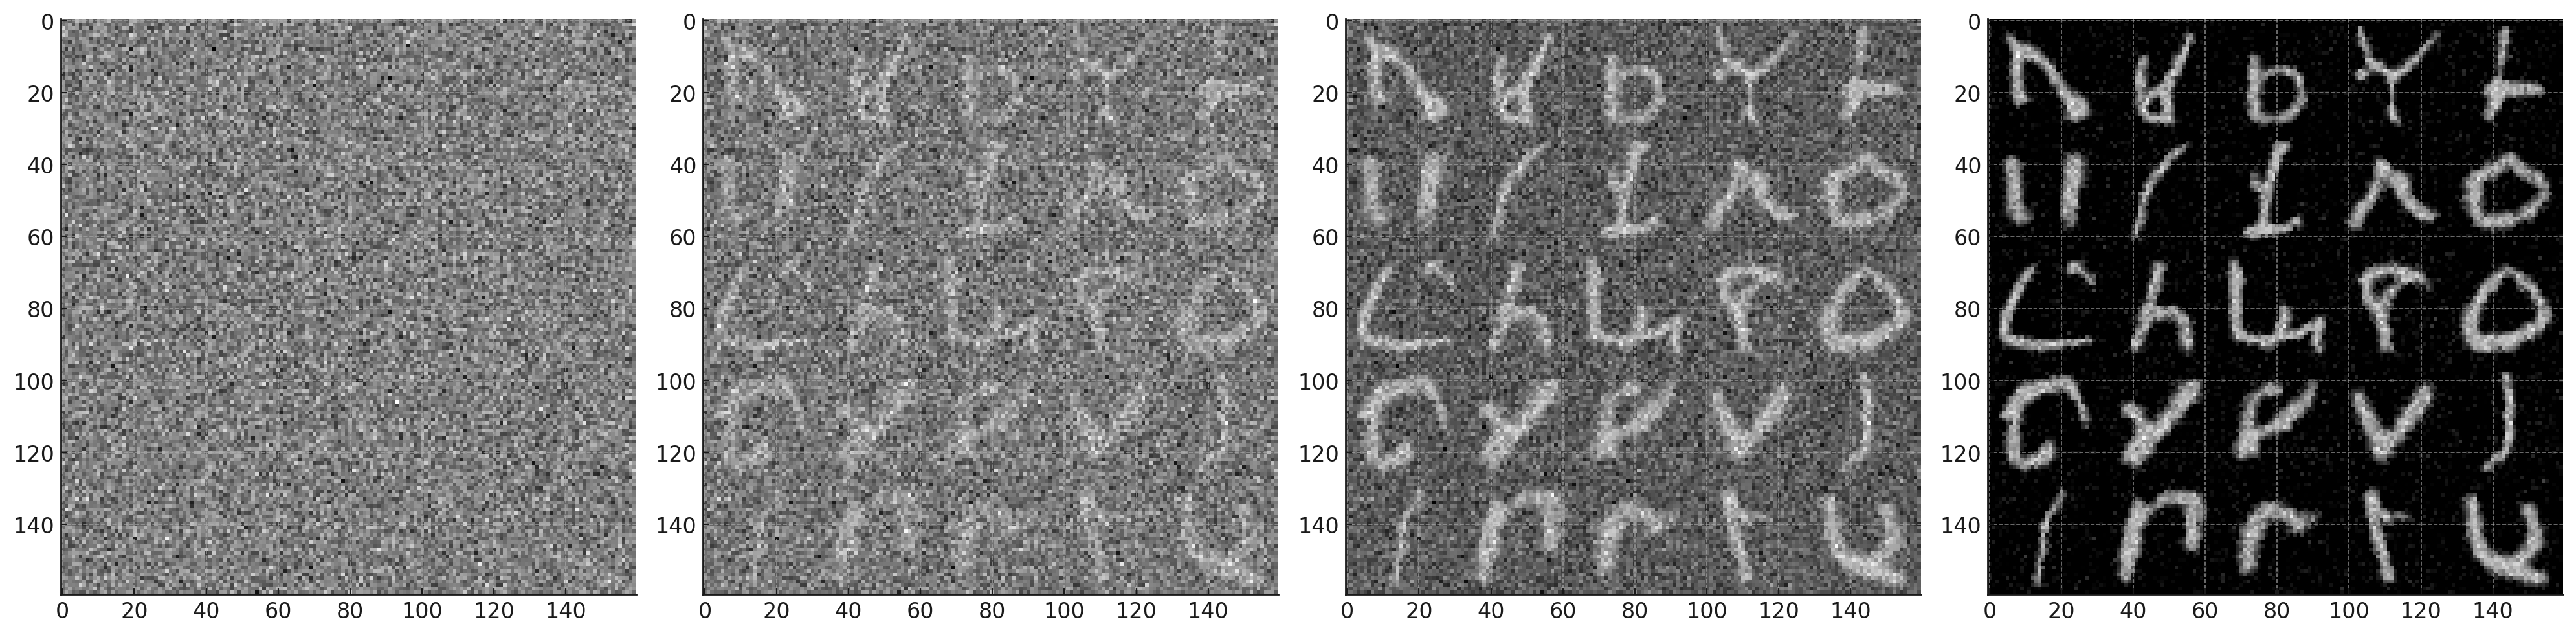

In [11]:
def draw_comapre_split(test_pred_bridges):
    n_sub_interval = 4
    print(n_sub_interval)
    fig, axs = plt.subplots(1, n_sub_interval, figsize=(5*n_sub_interval, 5))
    print(axs.shape)
    def plot_test_pred_bridges(sub_axs, data):
        data = data[0]
        print(data.shape)
        length = len(data)
        for i in range(4):
            now = data[int(length*i/4),:,0:1]
            img_array = torch.cat([torch.cat([now[j] for j in range(k, k+5)], dim=2) for k in range(0, 25, 5)], dim=1).permute(1,2,0).numpy()
            if i == n_sub_interval-1:
                percentile_1 = np.percentile(img_array, 60)
                percentile_99 = np.percentile(img_array, 100)
                img_array = np.clip((img_array - percentile_1) / (percentile_99 - percentile_1), 0, 1)
                # sub_axs[i].set_title("Source Distribution")
            else:
                img_array = (img_array-img_array.min())/(img_array.max()-img_array.min())
                # sub_axs[i].set_title("Target Distribution")
                
            sub_axs[i].imshow(img_array, cmap='gray')
            
    plot_test_pred_bridges(axs, test_pred_bridges)

    # set tight layout
    fig.tight_layout()
    
    # fig
    fig.show()
    
    return fig


draw_comapre_split(test_pred_bridges[-1]).savefig(log_dir / f'compare_{i}.png')

In [48]:
pred_bridge[i].shape, test_ts[i:i+1].shape, torch.zeros_like(test_ts[i:i+1]).shape, None

(torch.Size([25, 3, 32, 32]), torch.Size([1]), torch.Size([1]), None)

In [55]:
from torchsummary import summary
summary(model, input_size=[(3, 32, 32), (1,), (1,)], device='cuda', batch_size=25)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [25, 256]          16,640
              SiLU-2                  [25, 256]               0
            Linear-3                  [25, 256]          65,792
            Linear-4                  [25, 256]          16,640
              SiLU-5                  [25, 256]               0
            Linear-6                  [25, 256]          65,792
            Conv2d-7           [25, 64, 32, 32]           1,792
       GroupNorm32-8           [25, 64, 32, 32]             128
              SiLU-9           [25, 64, 32, 32]               0
           Conv2d-10           [25, 64, 32, 32]          36,928
             SiLU-11                  [25, 256]               0
           Linear-12                  [25, 128]          32,896
      GroupNorm32-13           [25, 64, 32, 32]             128
             SiLU-14           [25, 64,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
mnist_ds = torchvision.datasets.MNIST(
    root="./data/", 
    train=True, 
    download=True
    )

In [20]:
import numpy  as np
mnist_labels_78 = mnist_labels[np.logical_or(mnist_labels==7, mnist_labels==8)]

In [27]:
mnist_labels_arr = np.array(mnist_labels)
mnist_labels_78 = mnist_labels_arr[np.logical_or(mnist_labels_arr=='7', mnist_labels_arr=='8')]

In [29]:
mnist_labels_78.shape

(14118,)

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
mnist_data = mnist.data[np.logical_or(mnist_labels_arr=='7', mnist_labels_arr=='9')]
mnist_labels = mnist.target[np.logical_or(mnist_labels_arr=='7', mnist_labels_arr=='9')]

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
mnist_pca = pca.fit_transform(mnist_data)

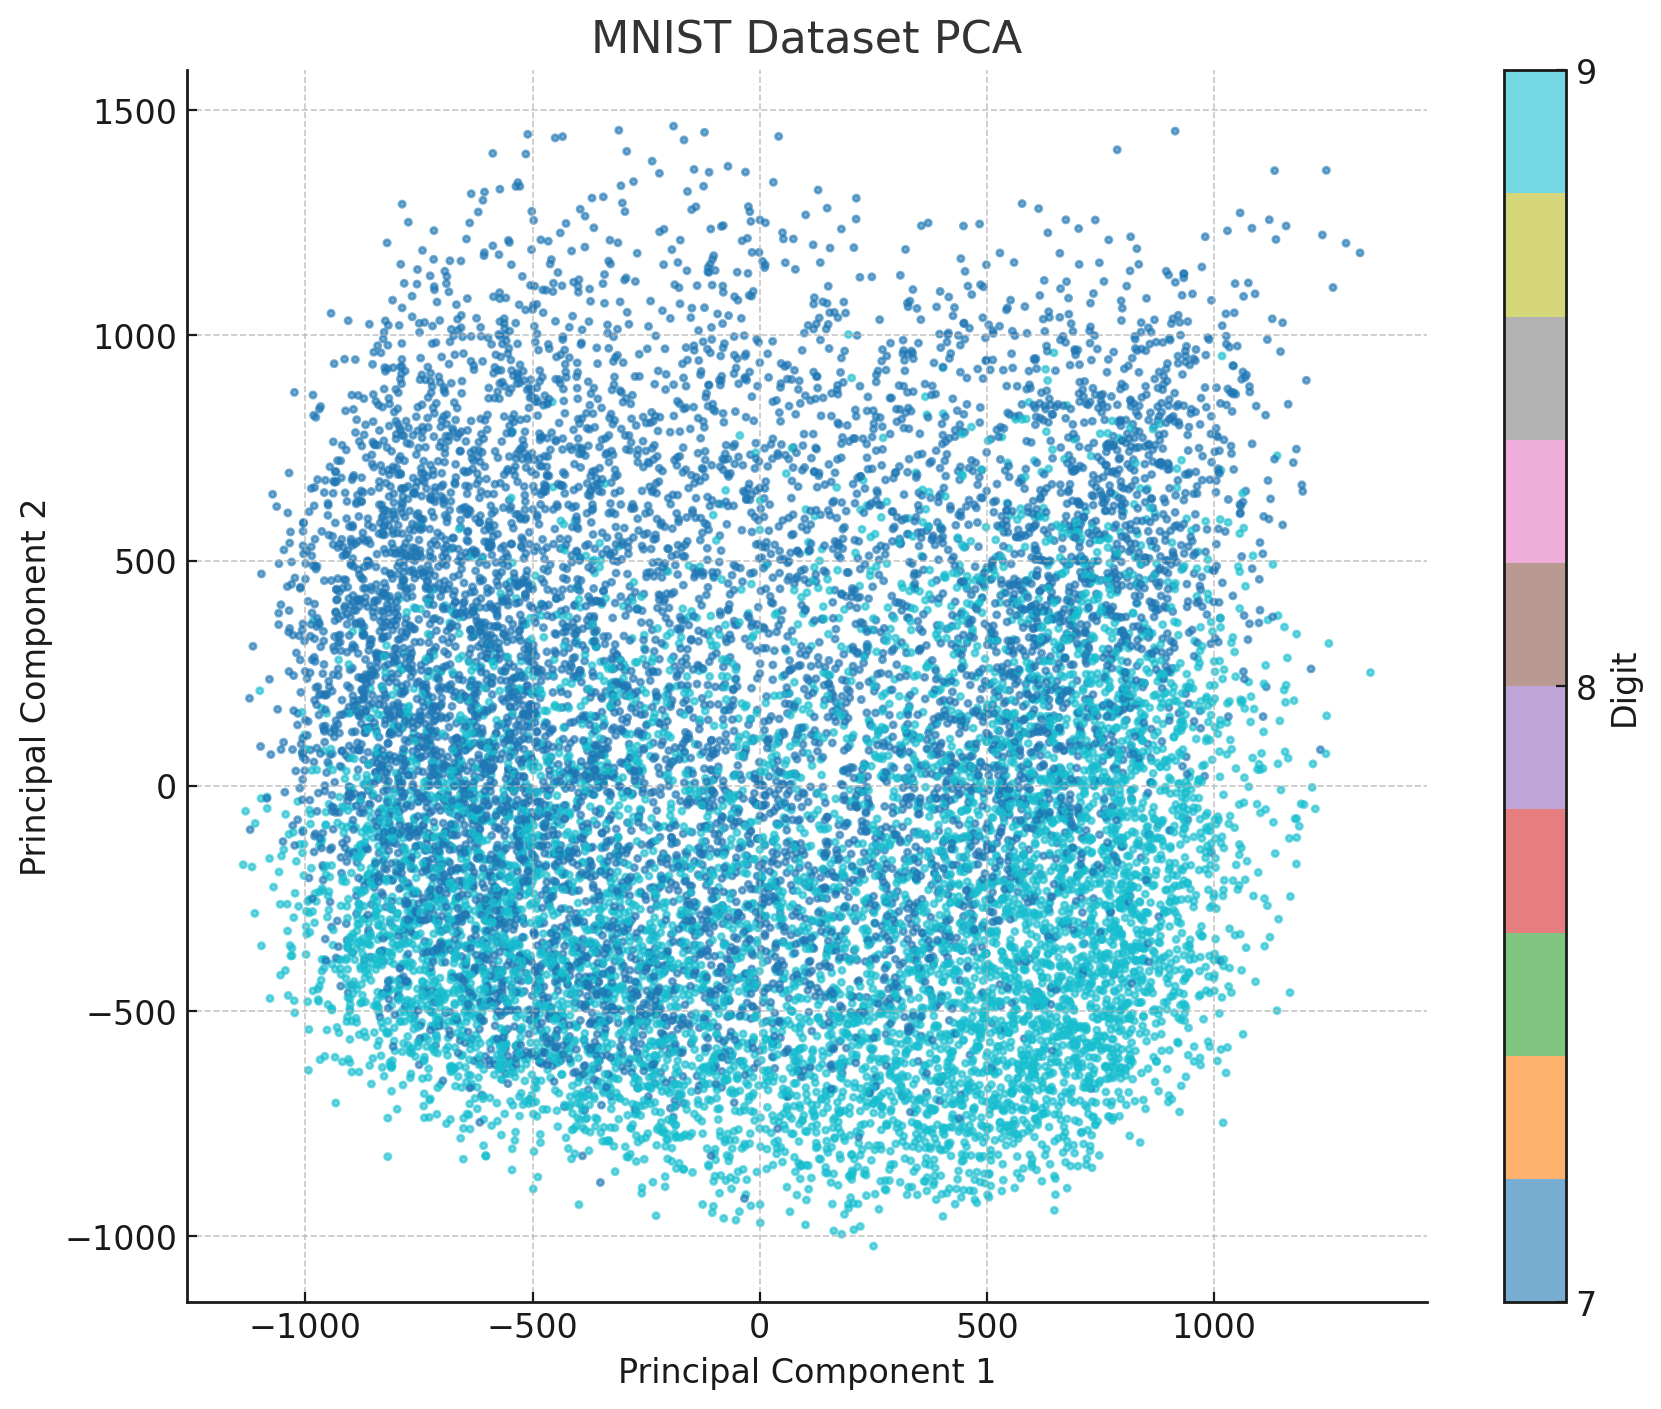

In [41]:
# Create a scatter plot with different colors for each digit
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mnist_pca[:, 0], mnist_pca[:, 1], c=mnist_labels.astype(int), cmap='tab10', s=5, alpha=0.6,marker='o')
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Dataset PCA')
plt.grid(True)
plt.show()